<a href="https://colab.research.google.com/github/norhum/deep_learning/blob/main/pytorch_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch

x, y = torch.empty(2, 3), torch.rand(2, 3)
z = torch.ones(1, 2, dtype=torch.float16)
print(z.size(), z.type())
print(z.shape, z.dtype)

torch.Size([1, 2]) torch.HalfTensor
torch.Size([1, 2]) torch.float16


In [ ]:
x, y = torch.rand(2, 2), torch.rand(2, 2)
z = x + y
z = torch.add(x, y)
y.add_(x) #underscore means in-place operation
y == z

tensor([[True, True],
        [True, True]])

In [2]:
import torch
import numpy as np

a= np.ones(5)
print(a)
b = torch.from_numpy(a)
a += 1
print(a, b)

if torch.cuda.is_available():
  device = torch.device('cuda')
  x = torch.ones(5, device=device)
  y = torch.ones(5)
  y = y.to(device)
  z = x+y
  z = z.to('cpu')
print(y.is_cuda)

[1. 1. 1. 1. 1.]
[2. 2. 2. 2. 2.] tensor([2., 2., 2., 2., 2.], dtype=torch.float64)
False


In [ ]:
import torch

a = torch.randn(3, 2, requires_grad=True)
b = 2*a + 2
print(b) #grad_fn=<AddBackward0>
b.backward(torch.ones(3, 2)) #torch.ones are the chainrule grad up to b
a.grad
#torch.backward assumes you have a scalar loss
#therefore the grad given is the chainrule grad up to a

tensor([[-0.8807,  1.8134],
        [ 1.2753, -0.1592],
        [ 3.5090,  3.4533]], grad_fn=<AddBackward0>)


tensor([[2., 2.],
        [2., 2.],
        [2., 2.]])

In [ ]:
import torch

x = torch.randn(2, 3, requires_grad=True)
x.requires_grad_(False) #in-place operation
y = x.detach()
with torch.no_grad():
  y = x + 2
  print(y)
print(x)

tensor([[2.5844, 2.6913, 0.7384],
        [2.6946, 1.3657, 2.7298]])
tensor([[ 0.5844,  0.6913, -1.2616],
        [ 0.6946, -0.6343,  0.7298]])


In [ ]:
import torch

weights = torch.ones(4, requires_grad=True)

for epoch in range(3):
  model_output = (weights*3).sum()
  model_output.backward()
  print(weights.grad)
  # weights.grad.zero_()

tensor([3., 3., 3., 3.])
tensor([6., 6., 6., 6.])
tensor([9., 9., 9., 9.])


In [ ]:
# linear regression
import torch
import torch.nn as nn
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt

#0 prepare data
x_numpy, y_numpy = datasets.make_regression(n_samples=100, n_features=1, noise=20, random_state=1)
print(y_numpy.shape)
x = torch.from_numpy(x_numpy.astype(np.float32))
y = torch.from_numpy(y_numpy.astype(np.float32))
y = y.view(y.shape[0], 1)
print(y.shape)
n_sample, n_features = x.shape

#1 model
input_size = n_features
output_size = 1
model = nn.Linear(input_size, output_size)

#2 loss and optimizer
learning_rate = 1e-2
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

#3 training loop
num_epochs = 100
for epoch in range(num_epochs):
  # forward pass and loss
  y_predicted = model(x)
  loss = criterion(y_predicted, y)

  #backward pass
  loss.backward()

  #update
  optimizer.step()

  optimizer.zero_grad()

  if epoch % 10 == 0:
    print(f'{epoch}: {loss:.4f}')

(100,)
torch.Size([100, 1])
0: 5670.6309
10: 4203.7324
20: 3142.4568
30: 2373.8171
40: 1816.5681
50: 1412.2013
60: 1118.5236
70: 905.0688
80: 749.8112
90: 636.8083


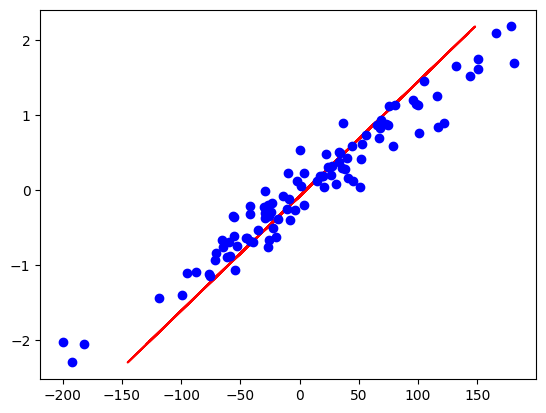

In [ ]:
#plot
predicted = y_predicted.detach().numpy()
plt.plot(predicted, x, 'r')
plt.plot(y, x, 'bo')
plt.show()

torch.Size([569, 30]) torch.Size([569, 1])
266501
0.6865 accuracy: 0.6274
0.0067 accuracy: 0.9930
0.0008 accuracy: 1.0000
0.0002 accuracy: 1.0000
0.0001 accuracy: 1.0000
0.0000 accuracy: 1.0000


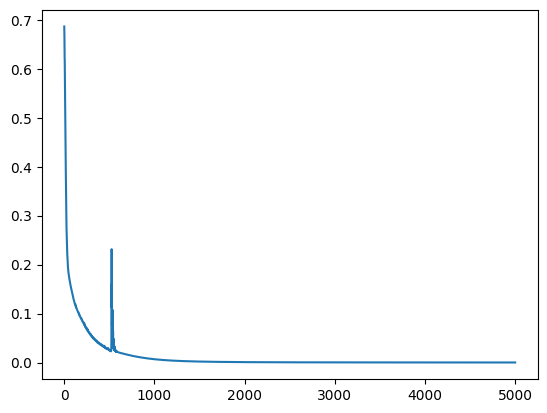

In [ ]:
#logistic regression
import torch
import torch.nn as nn
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt

torch.manual_seed(1)

# GPU setting
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#0 load data
data= datasets.load_breast_cancer()
x_data = torch.from_numpy(data.data.astype(np.float32)).to(device)
y_data = torch.from_numpy(data.target.astype(np.float32)).to(device)
y_data = y_data.view(y_data.shape[0], 1)
print(x_data.shape, y_data.shape)

#1 model
input_dim, output_dim = x_data.shape[1], y_data.shape[1] #30, 1
hid_dim = 500
model = nn.Sequential(
    nn.Linear(input_dim, hid_dim),
    nn.Sigmoid(),
    nn.Linear(hid_dim, hid_dim),
    nn.Sigmoid(),
    nn.Linear(hid_dim, output_dim),
    nn.Sigmoid()
).to(device)

print(sum(p.numel() for p in model.parameters()))

#2 loss, optimization
learning_rate = 1e-3
criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

#3 training loop
total_epoch = 5000
losses = []
for epoch in range(total_epoch+1):
  #forward pass
  prediction = model(x_data)
  loss = criterion(prediction, y_data)

  #backward pass and optimization
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()

  losses.append(loss.item())

  with torch.no_grad():
    if epoch % 1000 == 0:
      print(f'{loss.item():.4f}', end=' ')
      a = torch.squeeze(prediction>0.1)
      b = torch.squeeze(y_data>0)
      acc = sum(a==b)/y_data.shape[0]
      print(f'accuracy: {acc:.4f}')

#4 sketch
plt.plot(losses)
plt.show()

In [ ]:
prediction_class = prediction.round()
acc = prediction_class.eq(y_data).sum()/y_data.shape[0]
acc.data

tensor(1., device='cuda:0')

In [ ]:
#using dataset and dataloader
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torchvision
import math

class WineDataset(Dataset):

  def __init__(self, transform=None):
    super().__init__()
    xy = np.loadtxt('wine.txt', delimiter=',', dtype=np.float32, skiprows=1)
    self.x = torch.from_numpy(xy[:, 1:])
    self.y = torch.from_numpy(xy[:, [0]]) #xy[:,0] ->(n_samples), xy[:,[0]] ->(n_samples, 1)
    self.n_samples = xy.shape[0]
    # if using transform then we don't need to convert to tensor here
    self.x = xy[:, 1:]
    self.y = xy[:, [0]]

    self.transform = transform

  def __getitem__(self, index):
    sample = self.x[index], self,y[index]

    if self.transform:
      sample = self.transform(sample)

    return sample

  def __len__(self):
    return self.n_samples

class ToTensor:
  def __call__(self, sample):
    inputs, targets = sample
    return torch.from_numpy(inputs), torch.from_numpy(targets)

class MulTransform:
  def __init__(self, factor):
    self.factor = factor

  def __call__(self, sample):
    inputs, targets = sample
    inputs *= self.factor
    return inputs. targets

dataset = WineDataset()
dataloader = DataLoader(dataset=dataset, batch_size=4, shuffle=True, num_workers=2)

# features, labels = dataset[0] #gives 1
# #or
# dataiter = lter(dataloader)
# features, labels = next(dataiter) #gives 4 since batch_size=4

#training loop
num_epochs = 2
total_samples = len(dataset)
n_iterations = math.ceil(total_samples/4)

for epoch in range(num_epochs):
  for i, (inputs, labels) in enumerate(dataloader):
    #forward, backward, update
    if (i+1) % 5 == 0:
      print(f'epoch {epoch+1}/{num_epochs}, step {i+1}/{n_iterations}, inputs {inputs.shape}')

dataset = WineDataset(transform=ToTensor())
first_data = dataset[0]
features, labels = first_data
print(features)
print(type(features), type(labels)) #<class 'torch.Tensor'> if transform=None then numpy.ndarray

composed = torchvision.transforms.Compose([ToTensor(), MulTransform(2)])
dataset = WineDataset(transform=composed)

dataset = WineDataset(transform=composed)
first_data = dataset[0]
features, labels = first_data
print(features) #<twice as big as the one a above
print(type(features), type(labels)) #<class 'torch.Tensor'>

100%|██████████| 9912422/9912422 [00:00<00:00, 184652092.74it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 105703048.71it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 175655069.51it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 547554.86it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



torch.Size([256, 1, 28, 28]) torch.Size([256])


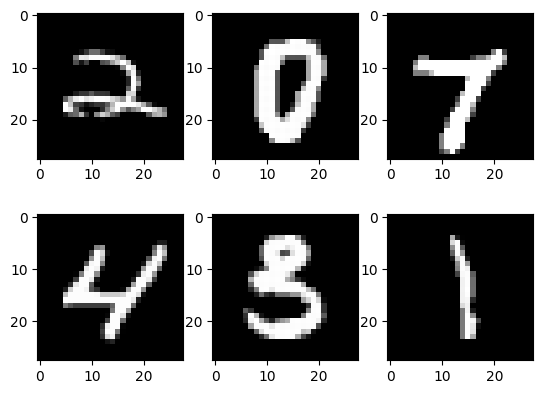

648010
epoch:1 
iter:0 loss:2.3091 accuracy: 0.0781
iter:100 loss:0.6676 accuracy: 0.8477
iter:200 loss:0.4207 accuracy: 0.8789
epoch:2 
iter:0 loss:0.3365 accuracy: 0.8867
iter:100 loss:0.3684 accuracy: 0.8828
iter:200 loss:0.1981 accuracy: 0.9492
epoch:3 
iter:0 loss:0.3020 accuracy: 0.9062
iter:100 loss:0.1872 accuracy: 0.9570
iter:200 loss:0.2684 accuracy: 0.9453
epoch:4 
iter:0 loss:0.2174 accuracy: 0.9414
iter:100 loss:0.2745 accuracy: 0.9023
iter:200 loss:0.2140 accuracy: 0.9531
epoch:5 
iter:0 loss:0.1358 accuracy: 0.9844
iter:100 loss:0.2436 accuracy: 0.9297
iter:200 loss:0.2310 accuracy: 0.9453
iter:233 loss:0.1767 accuracy: 0.9478


In [ ]:
#MNIST
#DataLoader, Transformation
#Multilayer Neural Net, Activation Function
#Loss and Optimizer
#Tranining Loop (batch training)
#Model Evaluation
#GPU Support

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

#device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # torch.device('cuda') vs 'cuda'

#hyper parameters
input_size = 784 # 28x28
hidden_size = 500
num_classes = 10
num_epochs = 5
batch_size= 256
learning_rate = 1e-4

#MNIST
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

example = iter(train_loader)
samples, labels = example.__next__() #example.next()doesn't work. next(example) works as well
print(samples.shape, labels.shape)

for i in range(6):
  plt.subplot(2, 3, i+1)
  plt.imshow(samples[i,0], cmap='gray') #samples[i,0] == samples[i][0]
plt.show()

class NeuralNet(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super().__init__() #super().__init__() vs super(NeuralNet, self).__init__()
    self.l1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.l2 = nn.Linear(hidden_size, hidden_size)
    self.relu = nn.ReLU()
    self.l3 = nn.Linear(hidden_size, num_classes)
    self.seq = nn.Sequential(self.l1, self.relu, self.l2, self.relu, self.l3)

  def forward(self, x):
    return self.seq(x)

model = NeuralNet(input_size, hidden_size, num_classes).to(device)

#loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
print(sum(p.numel() for p in model.parameters()))

#training loop
for epoch in range(num_epochs):
  print(f'epoch:{epoch+1} ')
  for i, (images, labels) in enumerate(train_loader):

    images = images.view(batch_size, -1).to(device)
    labels = labels.to(device)

    #forward pass
    prediction = model(images)
    loss = criterion(prediction, labels)

    #backward pass & update
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if i % 100 == 0:
      print(f'iter:{i} loss:{loss.item():.4f}', end=' ')

      #test
      with torch.no_grad():
        correct, indices = prediction.max(1)
        acc = sum(indices.eq(labels))
        accuracy = acc/batch_size
        print(f'accuracy: {accuracy:.4f}')

#using test_dataset, testing the whole dataset
with torch.no_grad():
  test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=len(test_dataset), shuffle=False, drop_last=True)
  images, labels = iter(test_loader).__next__()
  images = images.view(len(test_dataset), -1).to(device)
  labels = labels.to(device)
  prediction = model(images)

  print(f'iter:{i} loss:{loss.item():.4f}', end=' ')

  #test
  correct, indices = prediction.max(1)
  acc = sum(indices.eq(labels))
  accuracy = acc/len(test_dataset)
  print(f'accuracy: {accuracy:.4f}')

In [ ]:
image, label = train_dataset[0]
print(type(image), image.shape, type(label), label)
print(type(train_dataset), len(train_dataset))

image, label = iter(train_loader).__next__()
print(type(image), image.shape, type(label), label.shape)
print(type(train_loader), len(train_loader))

<class 'torch.Tensor'> torch.Size([1, 28, 28]) <class 'int'> 5
<class 'torchvision.datasets.mnist.MNIST'> 60000
<class 'torch.Tensor'> torch.Size([256, 1, 28, 28]) <class 'torch.Tensor'> torch.Size([256])
<class 'torch.utils.data.dataloader.DataLoader'> 234


In [ ]:
import torch
a= torch.tensor([[[1,0],[2,0],[3,0]],[[4,0],[5,0],[6,0]],[[7,0],[8,0],[9,0]],[[10,0],[11,0],[12,0]]]) #(4,3,2)
# a[1][2] == a[1,2]
a[1:3,2:,:]

tensor([[[6, 0]],

        [[9, 0]]])

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

#GPU support / device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#hyperparameters
num_epochs = 10
batch_size = 100
learning_rate = 1e-4
input_size = 1
num_classes = 10
kernel_size = 5

#MNIST data
train_data = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_data = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

train_dataset = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataset = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False, drop_last=True)

#CNN model
class CNNModel(nn.Module):
  def __init__(self, input_size, kernel_size):
    super().__init__()
    self.c1 = nn.Conv2d(input_size, 16, kernel_size) #28->24
    self.maxpool1 = nn.MaxPool2d(2, stride=2) #24->12
    self.relu1 = nn.ReLU()
    self.c2 = nn.Conv2d(16, 8, kernel_size) #12->8
    self.maxpool2 = nn.MaxPool2d(2, stride=2) #8->4
    self.relu2 = nn.ReLU()

    self.linear1 = nn.Linear(4*4*8, 4*8)
    self.linear2 = nn.Linear(4*8, num_classes)

    self.seq = nn.Sequential(self.c1, self.maxpool1, self.relu1, self.c2, self.maxpool2, self.relu2)

  def forward(self, x):
    x = self.seq(x)
    x = x.view(-1, 4*4*8)
    x = self.linear1(x)
    x = self.linear2(x)
    return x

model = CNNModel(input_size, kernel_size)

#loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
print(sum(p.numel() for p in model.parameters()))

#training loop
for epoch in range(num_epochs):
  for i, (sample, label) in enumerate(train_dataset):
    #forward pass
    prediction = model(sample)
    loss = criterion(prediction, label)

    #backward pass, optimize
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    #test
    with torch.no_grad():
      if i % 100 == 0:
        print(f'iter = {i}, loss = {loss.item():.4f}')

test = torch.utils.data.DataLoader(dataset=test_data, batch_size=len(test_data), shuffle=False, drop_last=True)
sample, label = next(iter(test))

prediction = model(sample)
value, indices = prediction.max(1)
accuracy = sum(indices.eq(label))/len(test_data)
print(f'accuracy: {accuracy:.4f}')

8082
iter = 0, loss = 2.3165
iter = 100, loss = 2.1725
iter = 200, loss = 1.6721
iter = 300, loss = 0.8657
iter = 400, loss = 0.6971
iter = 500, loss = 0.4038
iter = 0, loss = 0.4193
iter = 100, loss = 0.4131
iter = 200, loss = 0.4755
iter = 300, loss = 0.5245
iter = 400, loss = 0.2541
iter = 500, loss = 0.3445
iter = 0, loss = 0.2996
iter = 100, loss = 0.3664
iter = 200, loss = 0.3175
iter = 300, loss = 0.3393
iter = 400, loss = 0.2536
iter = 500, loss = 0.2015
iter = 0, loss = 0.4430
iter = 100, loss = 0.2588
iter = 200, loss = 0.3034
iter = 300, loss = 0.2607
iter = 400, loss = 0.3845
iter = 500, loss = 0.1332
iter = 0, loss = 0.2102
iter = 100, loss = 0.1731
iter = 200, loss = 0.3899
iter = 300, loss = 0.3081
iter = 400, loss = 0.1111
iter = 500, loss = 0.2431
iter = 0, loss = 0.2587
iter = 100, loss = 0.1604
iter = 200, loss = 0.2644
iter = 300, loss = 0.1892
iter = 400, loss = 0.1099
iter = 500, loss = 0.2677
iter = 0, loss = 0.1290
iter = 100, loss = 0.2059
iter = 200, loss = 0.

torch.Size([10000])
317


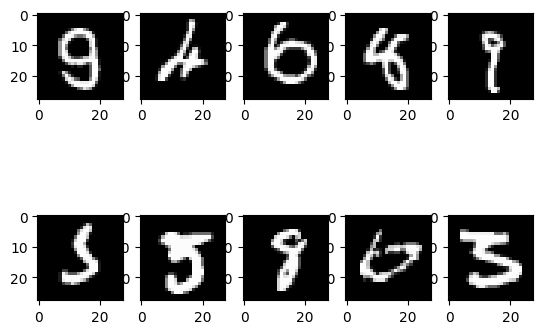

tensor([8, 2, 0, 4, 1, 3, 3, 7, 0, 5])


In [ ]:
test = torch.utils.data.DataLoader(dataset=test_data, batch_size=len(test_data), shuffle=False, drop_last=True)
sample, label = next(iter(test))
# print(sample.shape, label.shape)

prediction = model(sample)
# print(prediction.shape)
value, indices = prediction.max(1)

rorw = indices.eq(label)
print(rorw.shape)
find = []

for i in range(10000):
  if rorw[i] == False:
    find.append(i)

print(len(find))

for i in range(10):
  plt.subplot(2, 5, i+1)
  plt.imshow(sample[find[i],0], cmap='gray')
plt.show()
a, b = prediction[find[:10]].max(1)
print(b)
#should probably lose the pooling layer and make it deeper for better results

In [ ]:
#dimensionality reduction with encoder and decoder block separately made

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#hyperparameters
input_size = 784 # 28x28
batch_size = 256
lr = 1e-3
epoch = 10
hidden_size = 1024

#MNIST
transform = transforms.Compose([transforms.ToTensor()])
train_data = torchvision.datasets.MNIST(root='/data2', train=True, transform=transform, download=True)
train_dataset = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True, drop_last=True)

#model
class Encoder(nn.Module):
  def __init__(self, input_size, hidden_size):
    super().__init__()
    self.sq = nn.Sequential(
        nn.Linear(input_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size//8),
        nn.ReLU(),
        nn.Linear(hidden_size//8, hidden_size//64),
        nn.ReLU(),
        nn.Linear(hidden_size//64, 2)
    )

  def forward(self, x):
    return self.sq(x)

class Decoder(nn.Module):
  def __init__(self, input_size, hidden_size):
    super().__init__()
    self.sq = nn.Sequential(
        nn.Linear(2, hidden_size//64),
        nn.ReLU(),
        nn.Linear(hidden_size//64, hidden_size//8),
        nn.ReLU(),
        nn.Linear(hidden_size//8, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, input_size),
        nn.Sigmoid()
    )

  def forward(self, x):
    return self.sq(x)

class DimReduction(nn.Module):
  def __init__(self, input_size, hidden_size):
    super().__init__()
    self.two_dim = Encoder(input_size, hidden_size)
    self.out = Decoder(input_size, hidden_size)

  def forward(self, x):
    dim_reduct = self.two_dim(x)
    output = self.out(dim_reduct)
    return output, dim_reduct

model = DimReduction(input_size, hidden_size).to(device)

#loss and optimizer
# criterion = nn.MSELoss()
criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

#training loop
for i in range(epoch):
  for j, (example, label) in enumerate(train_dataset):
    #forward pass
    input = example.view(-1, 28*28).to(device)
    prediction, dim_reduct= model(input)
    loss = criterion(prediction, input)
    #backward pass and optimize
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    with torch.no_grad():
      if j % 100 == 0:
        print(f'iter:{i}, loss: {loss.item():.4f}')


iter:0, loss: 0.6934
iter:0, loss: 0.2481
iter:0, loss: 0.2149
iter:1, loss: 0.2156
iter:1, loss: 0.2020
iter:1, loss: 0.1936
iter:2, loss: 0.1853
iter:2, loss: 0.1810
iter:2, loss: 0.1891
iter:3, loss: 0.1910
iter:3, loss: 0.1883
iter:3, loss: 0.1822
iter:4, loss: 0.1850
iter:4, loss: 0.1827
iter:4, loss: 0.1815
iter:5, loss: 0.1816
iter:5, loss: 0.1706
iter:5, loss: 0.1808
iter:6, loss: 0.1749
iter:6, loss: 0.1753
iter:6, loss: 0.1757
iter:7, loss: 0.1810
iter:7, loss: 0.1724
iter:7, loss: 0.1687
iter:8, loss: 0.1687
iter:8, loss: 0.1734
iter:8, loss: 0.1770
iter:9, loss: 0.1717
iter:9, loss: 0.1786
iter:9, loss: 0.1725


torch.Size([60000, 1, 28, 28]) torch.Size([60000])
torch.Size([60000, 784])
torch.Size([60000, 784])


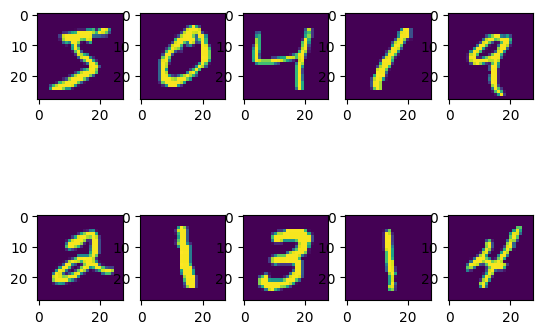

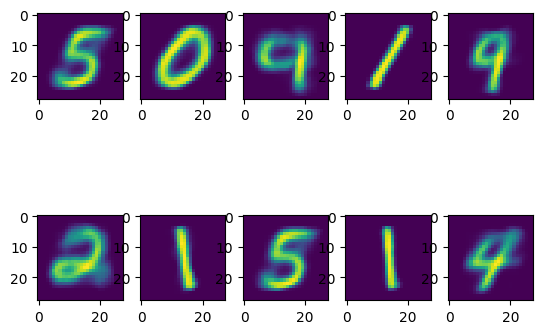

In [ ]:
train_dataset = torch.utils.data.DataLoader(dataset=train_data, batch_size = len(train_data))

sample, label = next(iter(train_dataset))
print(sample.shape, label.shape)
sample = sample.view(-1,28*28).to(device)
print(sample.shape)

prediction, dim_reduct = model(sample)
print(prediction.shape)

# acc = sum(torch.tensor(prediction).eq(input).view(-1))
# print(f'accuracy: {acc/(28*28*256):.4f}')
# prediction = prediction.view(-1,28,28).detach().numpy()

# for i in range(5):
#   plt.subplot(2, 5, i+1)
#   plt.imshow(sample[i], cmap='gray')
# for i in range(5, 10):
#   plt.subplot(2, 5, i+1)
#   plt.imshow(prediction[i], cmap='gray')

sample = sample.view(-1,28,28).cpu()
prediction = prediction.view(-1,28,28).cpu()
with torch.no_grad():
  for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(sample[i])
  plt.show()
  for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(prediction[i])
  plt.show()


[-1.3964088  -0.69145817]


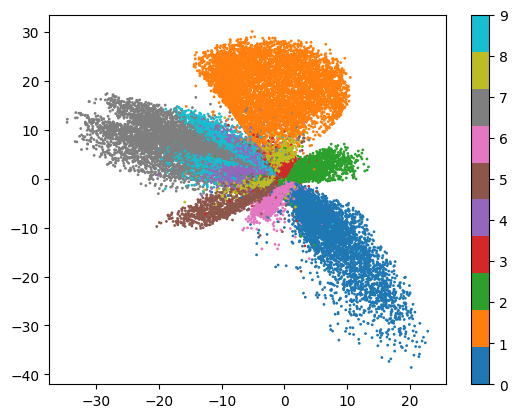

In [ ]:
dim_reduct = dim_reduct.cpu().detach().numpy()
print(dim_reduct[0])
y_target = label.cpu().detach().numpy()
plt.scatter(dim_reduct[:,0], dim_reduct[:,1], c=y_target, cmap='tab10', s=1) #I should probably study this
plt.colorbar()
plt.show()

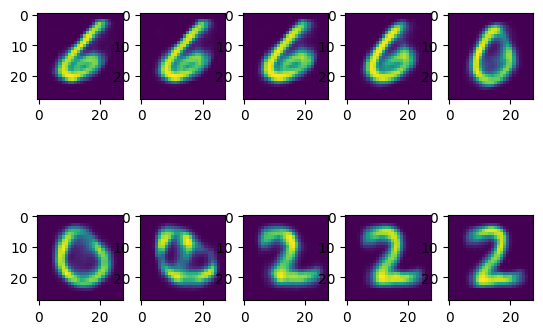

In [ ]:
B = [model.out(torch.tensor([-3+i, -7+i]).float().to(device)).view(28,28).cpu().detach().numpy() for i in range(10)]
for i in range(10):
  plt.subplot(2, 5, i+1)
  plt.imshow(B[i])
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_epochs = 1
batch_size = 4
learning_rate = 1e-4

#dataset has PILImage images of range[0, 1]
#we transform them to tensors of normalized range[-1, 1]
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = torchvision.datasets.CIFAR10(root='./data2', train=True, download=True, transform=transform)
test_data = torchvision.datasets.CIFAR10(root='./data2', train=False, download=True, transform=transform)
print(len(train_data))
train_dataset = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataset = torch.utils.data.DataLoader(dataset=test_data, batch_size=len(test_data), shuffle=False, drop_last=True)

classes = ('plain', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

class ConvNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.f1 = nn.Linear(16*5*5, 120)
    self.f2 = nn.Linear(120, 84)
    self.f3 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16*5*5)
    x = F.relu(self.f1(x))
    x = F.relu(self.f2(x))
    x = self.f3(x)
    return x

model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_dataset):
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    loss = criterion(outputs, labels)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if i % 2000 == 0:
      print(loss.item())

with torch.no_grad():
  correct = 0
  labels = {classes[i]:0 for i in range(10)}
  correct_labels = {classes[i]:0 for i in range(10)}
  labels_accuracy = {classes[i]:0 for i in range(10)}
  image, label = next(iter(test_dataset))
  prediction = model(image.to(device))
  data, indices = prediction.max(1)
  for i in range(10000):
    correct_labels[classes[indices[i]]] += 1
    if indices[i] == label[i]:
      labels[classes[indices[i]]] += 1
      correct += 1

  for i in range(10):
    labels_accuracy[classes[i]] = round(labels[classes[i]] / correct_labels[classes[i]], 3)
  accuracy = correct/10000
  print(f'{accuracy:.4f}')
  print(labels_accuracy)

Files already downloaded and verified
Files already downloaded and verified
50000
2.282931089401245
1.6249985694885254
2.102257490158081
2.0544252395629883
1.4698431491851807
1.5591316223144531
0.5727554559707642
0.4289
{'plain': 0.472, 'car': 0.529, 'bird': 0.32, 'cat': 0.313, 'deer': 0.427, 'dog': 0.342, 'frog': 0.464, 'horse': 0.415, 'ship': 0.584, 'truck': 0.472}


In [ ]:
import torch
import torchvision.transforms as transforms

x = torch.tensor([[[ 1.,  2.,  3.],
                   [ 4.,  5.,  6.]],
                  [[ 7.,  8.,  9.],
                   [10., 11., 12.]]])
#x.shape = (2,2,3)

#if the channel dimension is the 0th dimension
mean, std = x.mean((1,2)), x.std((1, 2))
print(mean, std)
norm = transforms.Normalize(mean,(1, 1))
print(norm(x))

#if the channel dimension is the 1th dimension
mean, std = x.mean((0,2)), x.std((0, 2))
print(mean, std)
norm = transforms.Normalize(mean,(1, 1))
norm(x) # by doing this, transforms.normalize thinks the 0th dimension is the channel dimension
norm(x.transpose(0, 1)) # this would normalize properly and also change x for the channel dimension to be the 0th dimension!

tensor([3.5000, 9.5000]) tensor([1.8708, 1.8708])
tensor([[[-2.5000, -1.5000, -0.5000],
         [ 0.5000,  1.5000,  2.5000]],

        [[-2.5000, -1.5000, -0.5000],
         [ 0.5000,  1.5000,  2.5000]]])
tensor([5., 8.]) tensor([3.4059, 3.4059])


tensor([[[-4., -3., -2.],
         [ 2.,  3.,  4.]],

        [[-4., -3., -2.],
         [ 2.,  3.,  4.]]])

In [ ]:
# going to build a better autoencoder model (change gray scale to rgb)
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

torch.manual_seed(1)

#gpu support
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#hyperparameters and etc
batch_size = 128
num_epochs = 5
learning_rate = 3e-4
input_size = 3
loss_iter = 100
layer = 4

transforms = transforms.Compose([transforms.ToTensor()])
loss_bin = [] #for plotting the loss

#MNIST data
train_dataset = datasets.CIFAR10(root='/train_data', train=True, download=True, transform=transforms)
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataset = datasets.CIFAR10(root='/test_data', train=False, download=True, transform=transforms)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

#model
class CNNAutoEncoder(nn.Module):
  def __init__(self, input_size):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Conv2d(1, 8, 5), #28*28
        nn.ReLU(),
        nn.Conv2d(8, 16, 5), #24*24
        nn.ReLU(),
        nn.Conv2d(16, 32, 5), #20*20
        nn.ReLU(),
        nn.Conv2d(32, 64, 5), #16*16
        nn.ReLU(),
        nn.Conv2d(64, 128, 5), #12*12
        nn.Tanh(),
    )
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(128, 64, 5),
        nn.ReLU(),
        nn.ConvTranspose2d(64, 32, 5),
        nn.ReLU(),
        nn.ConvTranspose2d(32, 16, 5),
        nn.ReLU(),
        nn.ConvTranspose2d(16, 8, 5),
        nn.ReLU(),
        nn.ConvTranspose2d(8, input_size, 5), #3*28*28
    )

  def forward(self, x):
    latent_space = self.encoder(x) #128*12*12
    output = self.decoder(latent_space)
    return output

class MLE(nn.Module): #multiple layers of autoencoders in parallel
  def __init__(self, input_size, layer):
    super().__init__()
    self.layers = nn.ModuleList([CNNAutoEncoder(input_size) for i in range(layer)])
    self.conv = nn.Conv2d(layer*input_size, input_size, kernel_size=3, stride=1, padding=1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    out = torch.cat([p(x) for p in self.layers], dim=1)
    out = self.sigmoid(self.conv(out))
    return out

model = MLE(input_size, layer).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#train
for epoch in range(num_epochs):
  lc = []
  for batch_iter, (image, label) in enumerate(train_dataloader):

      #forward pass
      image = image.to(device)
      gray_image = image[:,0]*0.3 + image[:,1]*0.59 + image[:,2]*0.11 #lunimosity method
      gray_image = gray_image.unsqueeze(1)
      prediction = model(gray_image)
      loss = criterion(prediction, image)

      #backward pass and optimize
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      #loss
      with torch.no_grad():
        lc.append(loss.item())
        if batch_iter % 100 == 0:
          loss = sum(lc)/len(lc)
          loss_bin.append(loss)
          print(f'epoch:{epoch}, {batch_iter}, loss:{loss:.4f}')


Files already downloaded and verified
Files already downloaded and verified
epoch:0, 0, loss:0.0635
epoch:0, 100, loss:0.0475
epoch:0, 200, loss:0.0365
epoch:0, 300, loss:0.0308
epoch:1, 0, loss:0.0169
epoch:1, 100, loss:0.0155
epoch:1, 200, loss:0.0150
epoch:1, 300, loss:0.0145
epoch:2, 0, loss:0.0119
epoch:2, 100, loss:0.0121
epoch:2, 200, loss:0.0120
epoch:2, 300, loss:0.0118
epoch:3, 0, loss:0.0109
epoch:3, 100, loss:0.0107
epoch:3, 200, loss:0.0107
epoch:3, 300, loss:0.0106
epoch:4, 0, loss:0.0111
epoch:4, 100, loss:0.0098
epoch:4, 200, loss:0.0099
epoch:4, 300, loss:0.0098


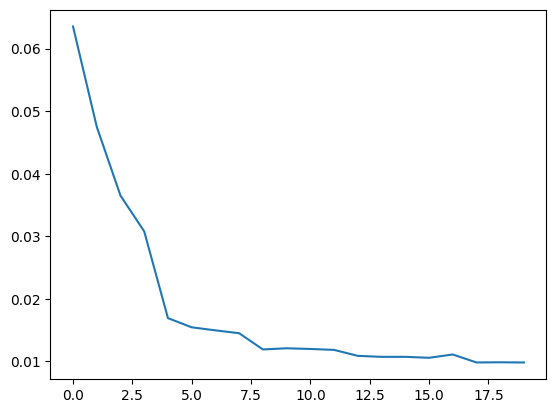

In [ ]:
#plot the loss
plt.plot(loss_bin)
plt.show()

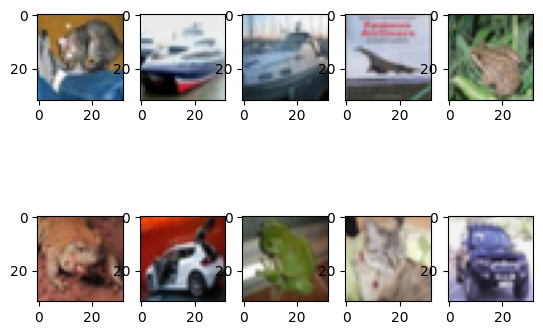

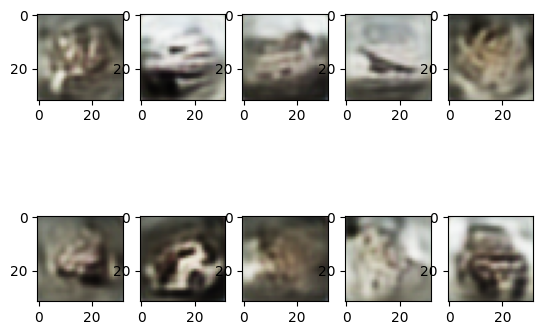

In [ ]:
a, b = next(iter(test_dataloader))
a = a.to(device)
b = a[:,0]*0.3 + a[:,1]*0.59 + a[:,2]*0.11
b = b.unsqueeze(1)
p = model(b)
a = a.transpose(1, 3).transpose(1, 2).cpu().detach().numpy()
b = b.transpose(1, 3).transpose(1, 2).cpu().detach().numpy()
p = p.transpose(1, 3).transpose(1, 2).cpu().detach().numpy()

for i in range(10):
  plt.subplot(2, 5, i+1)
  plt.imshow(a[i], cmap='gray')
plt.show()
for i in range(10):
  plt.subplot(2, 5, i+1)
  plt.imshow(p[i])
plt.show()
#sadly it doesn't represent rgb well

In [ ]:
#what i can do
#1. input data would be a black and white figure while the output is rgb
# make an auto encoder which basically puts color to it (from a different dataset like cifar10)
#2. an auto encoder while makes it less noisy or something that unmask parts that I've intentionally masked
# currently the latent_space is too big. I should lower it and find some cool stuff to do with the latent space(variational autencoder)
#3 train it in a different dataset and make the cifar10 dataset more clear. 32*32 pixel is just too blurry

In [ ]:
import torch
import torchvision
batch_size = 100
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
dataset = torchvision.datasets.CIFAR10(root='/data', download=True, transform=transforms)
dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, drop_last=True)


100%|██████████| 170498071/170498071 [00:05<00:00, 28484910.45it/s]


Extracting /data/cifar-10-python.tar.gz to /data


In [ ]:
import matplotlib.pyplot as plt
image, label = next(iter(dataloader))
print(image.shape, label.shape)
print(image[0])
# image = image.transpose(1, 3).transpose(1, 2).detach().cpu()
# for i in range(10):
#   plt.subplot(2, 5, i+1)
#   plt.imshow(image[i])
# plt.show()

torch.Size([100, 3, 32, 32]) torch.Size([100])
tensor([[[0.3255, 0.3216, 0.3216,  ..., 0.3255, 0.3255, 0.3255],
         [0.3255, 0.3176, 0.3176,  ..., 0.3216, 0.3216, 0.3216],
         [0.3294, 0.3176, 0.3176,  ..., 0.3176, 0.3176, 0.3216],
         ...,
         [0.3255, 0.4078, 0.3098,  ..., 0.3176, 0.3137, 0.3059],
         [0.3098, 0.3137, 0.2667,  ..., 0.3176, 0.3098, 0.3020],
         [0.2745, 0.2745, 0.2667,  ..., 0.3059, 0.2980, 0.2941]],

        [[0.4941, 0.4863, 0.4863,  ..., 0.4902, 0.4902, 0.4902],
         [0.4902, 0.4784, 0.4824,  ..., 0.4863, 0.4863, 0.4863],
         [0.4902, 0.4824, 0.4824,  ..., 0.4824, 0.4824, 0.4863],
         ...,
         [0.4392, 0.3843, 0.4157,  ..., 0.4784, 0.4667, 0.4706],
         [0.4353, 0.4314, 0.4353,  ..., 0.4745, 0.4627, 0.4667],
         [0.4431, 0.4431, 0.4314,  ..., 0.4627, 0.4549, 0.4549]],

        [[0.2000, 0.1882, 0.1843,  ..., 0.2000, 0.2000, 0.2000],
         [0.1961, 0.1843, 0.1843,  ..., 0.1922, 0.1922, 0.1961],
         [0

In [ ]:
a = torch.randn([2,3,5])
b = a[:,0]*1 + a[:,1]*0 + a[:,2]*1
a.shape, b.shape

(torch.Size([2, 3, 5]), torch.Size([2, 5]))

In [ ]:
#transfer learning
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import os
import copy

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        transforms.resize(256),
        transforms.CenterCrop(224),
    ]),
}
data_dir = #current directory
sets = ['train', 'val']
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in sets}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=0) for x in sets}
dataset_sizes = {x: len(image_datasets[x]) for x in sets}
class_names = image_datasets['train'].classes
print(class_names)

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.8

  for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs-1}')
    print('-'*10)

    #each epoch has a training and a validation phase
    for phase in sets:
      if phase == 'train':
        model.train() #set model to training mode
      else:
        model.eval()

      running_loss = 0.0
      running_corrects = 0

      #iterate over data
      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        #forward
        #track history if only in train
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)

          #backward + optimize only if in training phase
          if phase == 'train':
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        #statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

      if phase == 'train':
        scheduler.step()

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]

      print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

      #deep copy the model
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    print()

  print(f'Best val Acc: {best_acc:.4f}')

  #load best model weights
  model.load_state_dict(best_model_wts)
  return model

model = models.resnet18(pretrained=True)
num_features = model.fc.in_features

In [ ]:
from torchvision import models
import torch
import torch.nn as nn

model = models.resnet18(weights=True)

for param in model.parameters(): # this will freeze all the layers to stop updating
  param.requires_grad=False

num_ftrs = model.fc.in_features #input features of the fully connected layer(which is the last layer)
model.fc = nn.Linear(num_ftrs, 2) # since we only have 2 classes
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

#scheduler
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) #every 7 step lr will be multiplied by gamma

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=2)

#we usually first freeze all of the layers other than the newly added layer and train.
#Then unfreeze the layers and train the entire network using a sliced learning rate
#where the parameters of the later layers are updated faster than the params of the earlier layers

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
print(net)

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in net.state_dict():
    print(param_tensor, "\t", net.state_dict()[param_tensor].size())

print()

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
Model's state_dict:
conv1.weight 	 torch.Size([6, 3, 5, 5])
conv1.bias 	 torch.Size([6])
conv2.weight 	 torch.Size([16, 6, 5, 5])
conv2.bias 	 torch.Size([16])
fc1.weight 	 torch.Size([120, 400])
fc1.bias 	 torch.Size([120])
fc2.weight 	 torch.Size([84, 120])
fc2.bias 	 torch.Size([84])
fc3.weight 	 torch.Size([10, 84])
fc3.bias 	 torch.Size([10])

Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.001, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'maximize': False, 'foreach': None, 'differentiable': False, 'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}]
